<!-- Projeto Desenvolvido na Data Science Academy - www.datascienceacademy.com.br -->
# <font color='blue'>Data Science Academy</font>
## <font color='blue'>Deep Learning Para Aplicações de Inteligência Artificial com Python e C++</font>
## <font color='blue'>Projeto 2</font>
## <font color='blue'>Fine-Tuning de Um Modelo Transformer Para Classificação de Sentimento</font>

In [1]:
!pip install -q -U watermark

In [2]:
!pip install -q spacy

In [3]:
!pip install -q tensorflow

In [4]:
!pip install -q transformers

In [5]:
%env TF_CPP_MIN_LOG_LEVEL=3

env: TF_CPP_MIN_LOG_LEVEL=3


In [6]:
# Imports
import math
import nltk
import spacy
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import transformers
from tokenizers import BertWordPieceTokenizer
from tqdm import tqdm
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from tensorflow import keras
from keras.utils import to_categorical
from tensorflow.keras import Sequential
from tensorflow.keras.models import load_model
from keras.preprocessing.text import Tokenizer
from keras.metrics import Precision, Recall, AUC
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from keras.callbacks import EarlyStopping, LearningRateScheduler, CallbackList, ReduceLROnPlateau
from tensorflow.keras.optimizers.experimental import Adam
import warnings
warnings.filterwarnings('ignore')

In [7]:
%reload_ext watermark
%watermark -a "Data Science Academy"

Author: Data Science Academy



## Carregando os Dados de Texto

In [8]:
# Carrega os dados de treino
dados_dsa_treino = pd.read_csv('dados_treino.txt', header = None, delimiter = ';')

In [9]:
# Carrega os dados de teste
dados_dsa_teste = pd.read_csv('dados_teste.txt', header = None, delimiter = ';')

In [10]:
# Ajusta os nomes das colunas
dados_dsa_treino = dados_dsa_treino.rename(columns = {0: 'texto', 1: 'sentimento'})
dados_dsa_teste = dados_dsa_teste.rename(columns = {0: 'texto', 1: 'sentimento'})

In [11]:
# Shape
dados_dsa_treino.shape

(16000, 2)

In [12]:
# Shape
dados_dsa_teste.shape

(2000, 2)

In [13]:
# Amostra de treino
dados_dsa_treino.head()

,texto,sentimento
0,i am feeling completely overwhelmed i have two...,fear
1,i have the feeling she was amused and delighted,joy
2,i was able to help chai lifeline with your sup...,joy
3,i already feel like i fucked up though because...,anger
4,i still love my so and wish the best for him i...,sadness


> A coluna **texto** será a variável de entrada e **sentimento** a variável de saída.

In [14]:
# Sentimentos presentes nos dados de treino
dados_dsa_treino['sentimento'].value_counts()

joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: sentimento, dtype: int64

In [15]:
# Sentimentos presentes nos dados de teste
dados_dsa_teste['sentimento'].value_counts()

joy         695
sadness     581
anger       275
fear        224
love        159
surprise     66
Name: sentimento, dtype: int64

## Pré-Processamento dos Dados de Texto com SpaCy

https://spacy.io/

In [16]:
!python -m spacy download en_core_web_md -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 12.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [17]:
# Carrega o dicionário
dsa_nlp = spacy.load('en_core_web_md')

In [18]:
# Definição da função 'dsa_preprocessa_texto' que recebe um texto como parâmetro
def dsa_preprocessa_texto(text):

    # Processa o texto usando o dicionário
    doc = dsa_nlp(text)

    # Cria uma lista de lemas dos tokens, convertidos para minúsculas e sem espaços em branco,
    # excluindo as palavras que são stopwords
    tokens = [token.lemma_.lower().strip() for token in doc if not token.is_stop]

    # Retorna os tokens processados como uma string única, unindo-os com espaços
    return ' '.join(tokens)

In [19]:
# Aplica a função em treino
dados_dsa_treino['texto_processado'] = dados_dsa_treino['texto'].apply(dsa_preprocessa_texto)

In [20]:
# Aplica a função em teste
dados_dsa_teste['texto_processado'] = dados_dsa_teste['texto'].apply(dsa_preprocessa_texto)

In [21]:
# Amostra de dados
dados_dsa_treino.head()

,texto,sentimento,texto_processado
0,i am feeling completely overwhelmed i have two...,fear,feel completely overwhelmed strategy help feel...
1,i have the feeling she was amused and delighted,joy,feeling amuse delight
2,i was able to help chai lifeline with your sup...,joy,able help chai lifeline support encouragement ...
3,i already feel like i fucked up though because...,anger,feel like fuck not usually eat morning
4,i still love my so and wish the best for him i...,sadness,love wish good long tolerate effect bm life fa...


## Versão 1 do Modelo - Arquitetura Fully Connected Neural Network

### Passo1: Vetorização com TF-IDF

In [22]:
# Cria o vetorizador
dsa_tfidf = TfidfVectorizer(max_df = 0.95, min_df = 2, stop_words = 'english')

Esta linha acima cria uma instância do TfidfVectorizer da biblioteca scikit-learn, que é uma ferramenta utilizada para converter uma coleção de documentos brutos em uma matriz de recursos TF-IDF (Term Frequency-Inverse Document Frequency). O TF-IDF é uma técnica estatística usada para quantificar a importância de uma palavra em um conjunto de documentos, comumente utilizada em tarefas de processamento de linguagem natural e recuperação de informações.

**Parâmetro max_df=0.95**: Este parâmetro define o limite máximo de frequência de documento para os termos que serão considerados. Aqui, está definido como 0.95, o que significa que palavras que aparecem em mais de 95% dos documentos serão ignoradas. Isso ajuda a eliminar palavras comuns que não contribuem muito para o significado do texto.

**Parâmetro min_df=2**: Este parâmetro estabelece a frequência mínima de documento para os termos. Neste caso, termos que aparecem em menos de 2 documentos serão ignorados. Isso ajuda a filtrar termos raros que podem ocorrer apenas em poucas amostras e, portanto, são menos relevantes para a análise geral.

**Parâmetro stop_words='english'**: Este parâmetro instrui o vetorizador a remover todas as palavras de parada em inglês da análise. Palavras de parada são palavras comuns (como "e", "o", "em") que geralmente são filtradas em processamento de linguagem natural porque são muito frequentes e não carregam informações significativas para a análise de texto.

In [23]:
# Aplica o vetorizador
dados_treino_tfidf = dsa_tfidf.fit_transform(dados_dsa_treino['texto_processado'])
dados_teste_tfidf = dsa_tfidf.transform(dados_dsa_teste['texto_processado'])

In [24]:
dados_treino_tfidf.shape

(16000, 5587)

In [25]:
type(dados_treino_tfidf)

scipy.sparse._csr.csr_matrix

In [26]:
# Converte os dados de entrada (texto) para array
X_treino_array = dados_treino_tfidf.toarray()
X_teste_array = dados_teste_tfidf.toarray()

### Passo 2: Preparação dos Dados

Precisamos agora converter a variável alvo para representação numérica. Usaremos Label Encoding.

In [27]:
# Cria o label encoder
dsa_le_v1 = LabelEncoder()

In [28]:
# Faz o fit e transform na variável alvo em treino
y_treino_le = dsa_le_v1.fit_transform(dados_dsa_treino['sentimento'])

In [29]:
# Faz transform na variável alvo em teste
y_teste_le = dsa_le_v1.transform(dados_dsa_teste['sentimento'])

Vamos tratar de forma automática o desbalanceamento de classe.

In [30]:
# Peso das classes
pesos_classes = compute_class_weight('balanced', classes = np.unique(y_treino_le), y = y_treino_le)

In [31]:
type(pesos_classes)

numpy.ndarray

**compute_class_weight**: Esta é uma função do scikit-learn que calcula os pesos para as classes. Esses pesos podem ser usados em modelos de classificação para dar mais importância a classes que são sub-representadas no conjunto de dados.

**'balanced'**: Este parâmetro indica que os pesos das classes devem ser calculados de forma que equilibrem o conjunto de dados. Isso é feito inversamente proporcional à frequência das classes no conjunto de dados. Classes mais frequentes recebem um peso menor, enquanto classes menos frequentes recebem um peso maior.

**classes = np.unique(y_treino_le)**: Aqui, np.unique(y_treino_le) encontra todas as classes únicas no conjunto de dados de treinamento. O parâmetro classes informa à função compute_class_weight quais são essas classes únicas.

**y = y_treino_le**: Este é o vetor de rótulos do conjunto de dados de treinamento. A função usará esses rótulos para calcular a frequência de cada classe.

O resultado, armazenado em pesos_classes, é um array onde cada classe tem um peso associado. Esses pesos podem ser usados em modelos de classificação (como uma árvore de decisão, um modelo de regressão logística, SVM, etc.) para compensar o desequilíbrio entre as classes.

In [32]:
# Divisão em Dados de Treino e Teste (validação)
X_treino, X_val, y_treino, y_val = train_test_split(X_treino_array,
                                                    y_treino_le,
                                                    test_size = 0.2,
                                                    random_state = 42,
                                                    stratify = y_treino_le)

In [33]:
# Ajusta a variável alvo como tipo categórico
y_treino_encoded = to_categorical(y_treino)
y_teste_encoded = to_categorical(y_teste_le)
y_val_encoded = to_categorical(y_val)

In [34]:
# Shape
y_treino_encoded.shape, y_teste_encoded.shape, y_val_encoded.shape

((12800, 6), (2000, 6), (3200, 6))

### Passo 3:  Construção do Modelo

In [35]:
# Cria o modelo

# Inicializa um modelo sequencial. Modelos sequenciais são uma pilha linear de camadas.
modelo_dsa_v1 = Sequential()

# Adiciona a primeira camada densa (fully-connected) ao modelo
modelo_dsa_v1.add(Dense(4096,

                        # Utiliza a função de ativação SELU (Scaled Exponential Linear Unit)
                        activation = 'selu',

                        # Inicializa os pesos com a distribuição LeCun normal
                        kernel_initializer = 'lecun_normal',

                        # Define o formato da entrada com base no número de features do X_treino
                        input_shape = (X_treino.shape[1],),

                        # Aplica regularização L2 para reduzir o overfitting
                        kernel_regularizer = tf.keras.regularizers.l2(0.01)))

# Adiciona a segunda camada densa
modelo_dsa_v1.add(Dense(2048,
                        activation = 'selu',
                        kernel_initializer = 'lecun_normal',
                        kernel_regularizer = tf.keras.regularizers.l2(0.01)))

# Adiciona a terceira camada densa
modelo_dsa_v1.add(Dense(1024,
                        activation = 'selu',
                        kernel_initializer = 'lecun_normal',
                        kernel_regularizer = tf.keras.regularizers.l2(0.1)))

# Adiciona a quarta camada densa
# Camada com 64 neurônios e ativação SELU
modelo_dsa_v1.add(Dense(64, activation = 'selu',))

# Adiciona a camada de saída
# Camada de saída com 6 neurônios e ativação softmax para classificação multiclasse
modelo_dsa_v1.add(Dense(6, activation = 'softmax'))

### Passo 4:  Compilação e Sumário do Modelo

In [36]:
# Atribui pesos específicos ao vetor de bias da última camada do modelo
modelo_dsa_v1.layers[-1].bias.assign(pesos_classes)

<tf.Variable 'UnreadVariable' shape=(6,) dtype=float32, numpy=
array([1.2351397 , 1.3766993 , 0.49732688, 2.0449898 , 0.5715102 ,
       4.6620045 ], dtype=float32)>

In [37]:
# Compila o modelo
# Define o otimizador como 'Adam'.
# Adam é um algoritmo de otimização que pode ser usado no lugar do procedimento clássico de descida
# do gradiente estocástica para atualizar os pesos da rede iterativamente com base nos dados de treinamento.
# Define a função de perda como 'categorical_crossentropy'. É adequada para problemas de classificação
# multiclasse, onde os rótulos são fornecidos em um formato one-hot encoded.
# Define a métrica de avaliação do modelo como 'accuracy' (acurácia).
# A acurácia é uma métrica comum para avaliar o desempenho de modelos de classificação.
modelo_dsa_v1.compile(optimizer = 'Adam',
                      loss = tf.losses.categorical_crossentropy,
                      metrics = ['accuracy', Precision(), Recall(), AUC()])

In [38]:
modelo_dsa_v1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 4096)              22888448  
                                                                 
 dense_1 (Dense)             (None, 2048)              8390656   
                                                                 
 dense_2 (Dense)             (None, 1024)              2098176   
                                                                 
 dense_3 (Dense)             (None, 64)                65600     
                                                                 
 dense_4 (Dense)             (None, 6)                 390       
                                                                 
Total params: 33443270 (127.58 MB)
Trainable params: 33443270 (127.58 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Passo 5:  Callbacks e Early Stopping

In [39]:
# Função para os parâmetros de scheduler da taxa de aprendizado
def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop, math.floor((1 + epoch) / epochs_drop))
    return lrate

In [40]:
# Scheduler da taxa de aprendizado
lr_scheduler = LearningRateScheduler(step_decay)

In [41]:
# Early Stopping
early_stopping = EarlyStopping(monitor = 'val_loss', restore_best_weights = True, patience = 3)

### Passo 6:  Treinamento do Modelo

In [42]:
# Hiperparâmetros
num_epochs = 20
tamanho_batch = 256

Treinamento do modelo.

In [43]:
%%time
history = modelo_dsa_v1.fit(X_treino,
                            y_treino_encoded,
                            validation_data = (X_val, y_val_encoded),
                            epochs = num_epochs,
                            batch_size = tamanho_batch,
                            callbacks = [early_stopping, lr_scheduler])

Epoch 1/20
50/50 [==============================] - 7s 44ms/step - loss: 37.2173 - accuracy: 0.6677 - precision: 0.8045 - recall: 0.4801 - auc: 0.9020 - val_loss: 2.2525 - val_accuracy: 0.7991 - val_precision: 0.8741 - val_recall: 0.6769 - val_auc: 0.9664 - lr: 0.0010
Epoch 2/20
50/50 [==============================] - 1s 29ms/step - loss: 1.4963 - accuracy: 0.8032 - precision: 0.8750 - recall: 0.7105 - auc: 0.9674 - val_loss: 1.3803 - val_accuracy: 0.7547 - val_precision: 0.8172 - val_recall: 0.6928 - val_auc: 0.9585 - lr: 0.0010
Epoch 3/20
50/50 [==============================] - 2s 31ms/step - loss: 1.1989 - accuracy: 0.8247 - precision: 0.8827 - recall: 0.7541 - auc: 0.9744 - val_loss: 1.1871 - val_accuracy: 0.8219 - val_precision: 0.8675 - val_recall: 0.7547 - val_auc: 0.9742 - lr: 0.0010
Epoch 4/20
50/50 [==============================] - 1s 29ms/step - loss: 1.0490 - accuracy: 0.8597 - precision: 0.9028 - recall: 0.8093 - auc: 0.9820 - val_loss: 1.1619 - val_accuracy: 0.8150 - v

### Passo 7:  Avaliação do Modelo

In [44]:
# Extrai o erro em treino e validação
loss, val_loss = history.history['loss'], history.history['val_loss']

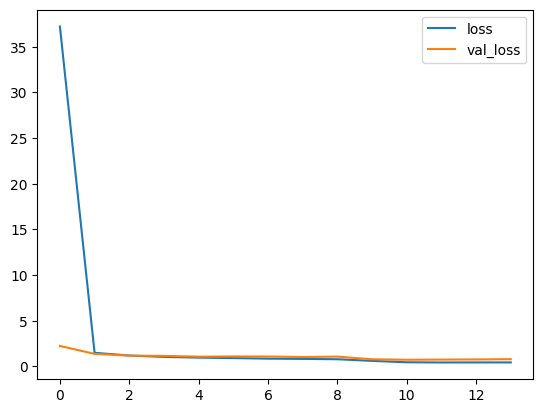

In [45]:
# Plot
plt.plot(loss, label = 'loss')
plt.plot(val_loss, label = 'val_loss')
plt.legend()
plt.show()

In [46]:
# Previsões com dados de teste
previsoes_v1 = modelo_dsa_v1.predict(X_teste_array)

63/63 [==============================] - 0s 3ms/step


In [47]:
# Extrai os labels
previsoes_v1_labels = previsoes_v1.argmax(axis = 1)

In [48]:
print(classification_report(y_teste_le, previsoes_v1_labels))

              precision    recall  f1-score   support

           0       0.88      0.82      0.85       275
           1       0.76      0.88      0.82       224
           2       0.88      0.89      0.89       695
           3       0.69      0.79      0.73       159
           4       0.91      0.85      0.88       581
           5       0.77      0.61      0.68        66

    accuracy                           0.85      2000
   macro avg       0.81      0.81      0.81      2000
weighted avg       0.86      0.85      0.85      2000



In [49]:
print(confusion_matrix(y_teste_le, previsoes_v1_labels))

[[225  13  12   4  21   0]
 [  6 198   6   0  11   3]
 [  4   9 621  42  11   8]
 [  2   2  25 125   4   1]
 [ 20  20  34  11 496   0]
 [  0  17   8   0   1  40]]


In [50]:
print(accuracy_score(y_teste_le, previsoes_v1_labels))

0.8525


In [51]:
# Salva o modelo
modelo_dsa_v1.save('modelo_dsa_v1.keras')

### Passo 8:  Deploy da Versão 1 do Modelo

In [52]:
# Carrega o modelo
modelo_carregado = load_model('modelo_dsa_v1.keras')

In [53]:
# Nova frase (sentimento = medo (fear))
frase = "i even feel a little shaky"

In [54]:
# Cria um dataframe com a frase
df_novo = pd.DataFrame({'Frase': [frase]})

In [55]:
# Aplica a função de processamento
df_novo['Frase_Processada'] = df_novo['Frase'].apply(dsa_preprocessa_texto)

In [56]:
df_novo

,Frase,Frase_Processada
0,i even feel a little shaky,feel little shaky


In [57]:
# Aplica a vetorização
df_novo_tfidf = dsa_tfidf.transform(df_novo['Frase_Processada'])

In [58]:
# Transforma em array
df_novo_array = df_novo_tfidf.toarray()

In [59]:
# Previsões
previsoes = modelo_carregado.predict(df_novo_array)

1/1 [==============================] - 0s 98ms/step


In [60]:
previsoes

array([[3.0770266e-04, 9.9797982e-01, 6.4206932e-04, 7.2632361e-08,
        4.0883091e-04, 6.6150789e-04]], dtype=float32)

In [61]:
# Seleciona a classe com maior probabilidade
classe_maior_prob = np.argmax(previsoes, axis = 1)

In [62]:
classe_maior_prob

array([1])

In [63]:
# Obtém o nome da classe
nome_classe = dsa_le_v1.inverse_transform(classe_maior_prob)

In [64]:
# Classe prevista
nome_classe

array(['fear'], dtype=object)

## Versão 2 do Modelo - LSTM (Long Short-Term Memory)

Usaremos os dados processados com SpaCy e então faremos o processamento específico para o modelo LSTM, assim como fizemos com o modelo da versão 1.

In [65]:
# Dados processados com SpaCy
dados_dsa_treino.head()

,texto,sentimento,texto_processado
0,i am feeling completely overwhelmed i have two...,fear,feel completely overwhelmed strategy help feel...
1,i have the feeling she was amused and delighted,joy,feeling amuse delight
2,i was able to help chai lifeline with your sup...,joy,able help chai lifeline support encouragement ...
3,i already feel like i fucked up though because...,anger,feel like fuck not usually eat morning
4,i still love my so and wish the best for him i...,sadness,love wish good long tolerate effect bm life fa...


In [66]:
# Criação do tokenizador
# from keras.preprocessing.text import Tokenizer
dsa_tokenizador = Tokenizer()

In [67]:
# Ajuste do tokenizador com os textos processados
dsa_tokenizador.fit_on_texts(dados_dsa_treino['texto_processado'])

In [68]:
# Extrai o índice de palavras
word_index = dsa_tokenizador.word_index

In [69]:
len(word_index)

11897

In [70]:
# Itera sobre os pares chave-valor do dicionário
for i, (chave, valor) in enumerate(word_index.items()):
    print(chave, valor)
    # Interrompe o loop após imprimir 10 itens
    if i == 9:
        break

feel 1
like 2
m 3
not 4
feeling 5
know 6
time 7
t 8
want 9
think 10


In [71]:
# Conversão dos textos de treino para sequências de tokens
sequencias_treino = dsa_tokenizador.texts_to_sequences(dados_dsa_treino['texto_processado'])

In [72]:
# Definindo o comprimento máximo das sequências
max_length = 100

In [73]:
# Padding das sequências de treino
sequencias_treino_padded = pad_sequences(sequencias_treino, maxlen = max_length, truncating = 'post')

O "padding" é uma técnica comumente usada no processamento de sequências de dados, especialmente em tarefas de processamento de linguagem natural (PLN). O padding é usado para padronizar o comprimento das sequências. Isso é feito adicionando um valor especial (geralmente 0) no início ou no final das sequências para aumentá-las até um comprimento máximo definido. Isso permite que o modelo processe lotes de sequências simultaneamente, o que é essencial para a eficiência do treinamento.

Na linha acima:

**maxlen = max_length**: Este argumento define o comprimento máximo das sequências após o padding. Se uma sequência for mais curta que max_length, ela será estendida com zeros até alcançar esse comprimento. Se for mais longa, será truncada.

**truncating = 'post'**: Este argumento especifica como as sequências devem ser truncadas para o comprimento máximo, caso sejam mais longas que max_length. O valor 'post' indica que o truncamento deve ocorrer no final da sequência. Alternativamente, 'pre' truncaria no início.

O resultado, sequencias_treino_padded, será uma matriz onde cada sequência tem exatamente max_length elementos, com padding de zeros adicionado conforme necessário. Isso torna as sequências compatíveis com muitos modelos de aprendizado de máquina, especialmente aqueles usados em PLN.

In [74]:
# Conversão dos textos de teste para sequências de tokens
sequencias_teste = dsa_tokenizador.texts_to_sequences(dados_dsa_teste['texto_processado'])

In [75]:
# Padding das sequências de teste
sequencias_teste_padded = pad_sequences(sequencias_teste, maxlen = max_length)

In [76]:
# Criação do codificador de rótulos
dsa_le_v2 = LabelEncoder()

In [77]:
# Fit e transform dos rótulos de sentimento para treino
y_treino_le = dsa_le_v2.fit_transform(dados_dsa_treino['sentimento'])

In [78]:
# Transformação dos rótulos de sentimento para teste
y_teste_le = dsa_le_v2.transform(dados_dsa_teste['sentimento'])

In [79]:
# Conversão dos rótulos em variáveis categóricas
y_treino_encoded = to_categorical(y_treino_le)
y_teste_encoded = to_categorical(y_teste_le)

In [80]:
# Definindo o tamanho do vocabulário
vocab_size = len(dsa_tokenizador.word_index) + 1

In [81]:
print(vocab_size)

11898


In [82]:
# Definindo a dimensão do embedding
embedding_dim = max_length

In [83]:
# Construção do modelo LSTM
modelo_dsa_v2 = tf.keras.Sequential([Embedding(vocab_size, embedding_dim, input_length = max_length),
                                     Bidirectional(LSTM(64)),
                                     Dropout(0.4),
                                     Dense(32, activation = 'leaky_relu', kernel_regularizer = 'l1_l2'),
                                     Dropout(0.4),
                                     Dense(6, activation = 'softmax')])

In [84]:
# Compilação do modelo
modelo_dsa_v2.compile(loss = 'categorical_crossentropy',
                      optimizer = 'adam',
                      metrics = ['accuracy', Precision(), Recall(), AUC()])

In [85]:
# Exibindo o resumo do modelo
print(modelo_dsa_v2.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          1189800   
                                                                 
 bidirectional (Bidirection  (None, 128)               84480     
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 32)                4128      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_6 (Dense)             (None, 6)                 198       
                                                      

In [86]:
# Definindo os dados de entrada como array
dados_entrada = np.array(sequencias_treino_padded)

In [87]:
# Definindo os dados de saída como array
dados_saida = np.array(y_treino_encoded)

In [88]:
# Definição de hiperparâmetros
num_epochs = 35
validation_split_value = 0.2
paciencia = 5

In [89]:
# Configuração de Early Stopping
early_stopping = tf.keras.callbacks.EarlyStopping(patience = paciencia)

> Treinamento do Modelo.

In [90]:
%%time
history = modelo_dsa_v2.fit(dados_entrada,
                            dados_saida,
                            epochs = num_epochs,
                            verbose = 1,
                            validation_split = validation_split_value,
                            callbacks = [early_stopping])

Epoch 1/35
400/400 [==============================] - 27s 55ms/step - loss: 2.4435 - accuracy: 0.3224 - precision_1: 0.4444 - recall_1: 6.2500e-04 - auc_1: 0.7029 - val_loss: 1.6211 - val_accuracy: 0.3262 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - val_auc_1: 0.7234
Epoch 2/35
400/400 [==============================] - 8s 20ms/step - loss: 1.4613 - accuracy: 0.3617 - precision_1: 0.5007 - recall_1: 0.0845 - auc_1: 0.7969 - val_loss: 1.2953 - val_accuracy: 0.4238 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - val_auc_1: 0.8471
Epoch 3/35
400/400 [==============================] - 6s 14ms/step - loss: 1.2316 - accuracy: 0.4306 - precision_1: 0.5146 - recall_1: 0.1839 - auc_1: 0.8611 - val_loss: 1.2199 - val_accuracy: 0.4247 - val_precision_1: 0.5660 - val_recall_1: 0.1541 - val_auc_1: 0.8618
Epoch 4/35
400/400 [==============================] - 6s 16ms/step - loss: 1.1348 - accuracy: 0.4531 - precision_1: 0.5380 - recall_1: 0.2321 - auc_1: 0.8764 - val_loss: 1.

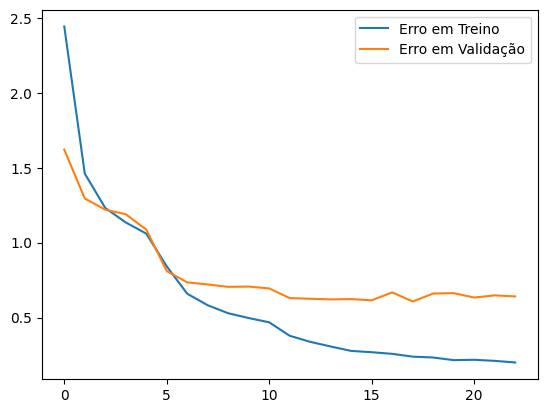

In [91]:
# Plot das curvas de erro
loss, val_loss = history.history['loss'], history.history['val_loss']
plt.plot(loss, label = 'Erro em Treino')
plt.plot(val_loss, label = 'Erro em Validação')
plt.legend()
plt.show()

In [92]:
# Previsões com dados de teste
previsoes = modelo_dsa_v2.predict(sequencias_teste_padded)

63/63 [==============================] - 1s 6ms/step


In [93]:
# Determinação dos rótulos previstos
labels_previstos = previsoes.argmax(axis = 1)

In [94]:
# Exibição do relatório de classificação
print(classification_report(y_teste_le, labels_previstos))

              precision    recall  f1-score   support

           0       0.90      0.86      0.88       275
           1       0.87      0.86      0.86       224
           2       0.91      0.92      0.91       695
           3       0.73      0.73      0.73       159
           4       0.92      0.94      0.93       581
           5       0.74      0.70      0.72        66

    accuracy                           0.89      2000
   macro avg       0.85      0.83      0.84      2000
weighted avg       0.89      0.89      0.89      2000



In [95]:
# Exibição da matriz de confusão
print(confusion_matrix(y_teste_le, labels_previstos))

[[237   8   9   3  18   0]
 [ 12 193   3   1   6   9]
 [  1   2 637  34  15   6]
 [  1   3  31 116   7   1]
 [ 10   7  14   4 546   0]
 [  1  10   7   1   1  46]]


In [96]:
# Exibição da precisão do modelo
print(accuracy_score(y_teste_le, labels_previstos))

0.8875


In [97]:
# Salva o modelo
modelo_dsa_v2.save('modelo_dsa_v2.keras')

> Deploy do Modelo.

In [98]:
# Carrega o modelo salvo
modelo_carregado = load_model('modelo_dsa_v2.keras')

In [99]:
# Nova frase (sentimento = medo (fear))
frase = "i even feel a little shaky"

In [100]:
# Cria um dataframe com a frase
df_novo = pd.DataFrame({'Frase': [frase]})

In [101]:
# Aplica a função de processamento
df_novo['Frase_Processada'] = df_novo['Frase'].apply(dsa_preprocessa_texto)

In [102]:
# Processar os novos dados
sequencias_novos = dsa_tokenizador.texts_to_sequences(df_novo['Frase_Processada'])
sequencias_novos_padded = pad_sequences(sequencias_novos, maxlen = max_length)

In [103]:
# Fazer previsões com o modelo carregado
previsoes = modelo_carregado.predict(sequencias_novos_padded)

1/1 [==============================] - 1s 901ms/step


In [104]:
# Seleciona a classe com maior probabilidade
classe_maior_prob = np.argmax(previsoes, axis = 1)

In [105]:
classe_maior_prob

array([1])

In [106]:
# Obtém o nome da classe
nome_classe = dsa_le_v2.inverse_transform(classe_maior_prob)

In [107]:
# Classe prevista
nome_classe

array(['fear'], dtype=object)

## Versão 3 do Modelo - Fine Tuning de Modelo Transformer Pré-Treinado

Usaremos os dados processados com SpaCy e então faremos o processamento específico para o modelo BERT, assim como fizemos com o modelo da versão 1.

In [108]:
# Dados processados com SpaCy
dados_dsa_treino.head()

,texto,sentimento,texto_processado
0,i am feeling completely overwhelmed i have two...,fear,feel completely overwhelmed strategy help feel...
1,i have the feeling she was amused and delighted,joy,feeling amuse delight
2,i was able to help chai lifeline with your sup...,joy,able help chai lifeline support encouragement ...
3,i already feel like i fucked up though because...,anger,feel like fuck not usually eat morning
4,i still love my so and wish the best for him i...,sadness,love wish good long tolerate effect bm life fa...


In [109]:
# Função para codificar o texto em sequência de inteiros para entrada do modelo BERT
def dsa_encode(texts, tokenizer, chunk_size = 256, maxlen = 512):

    # Ativar truncamento no tokenizador para um comprimento máximo especificado
    tokenizer.enable_truncation(max_length = maxlen)

    # Ativar padding no tokenizador para um comprimento específico
    tokenizer.enable_padding(length = maxlen)

    # Inicializar uma lista para armazenar os IDs codificados
    all_ids = []

    # Iterar sobre os textos em pedaços de tamanho 'chunk_size'
    for i in tqdm(range(0, len(texts), chunk_size)):

        # Criar um pedaço (chunk) do texto
        text_chunk = texts[i:i+chunk_size].tolist()

        # Codificar o pedaço do texto em lote
        encs = tokenizer.encode_batch(text_chunk)

        # Estender a lista 'all_ids' com os IDs codificados
        all_ids.extend([enc.ids for enc in encs])

    # Retorna a lista de IDs como um array numpy
    return np.array(all_ids)

https://huggingface.co/distilbert-base-multilingual-cased

In [110]:
# Carrega o tokenizador do modelo pré-treinado
tokenizador_bert = transformers.DistilBertTokenizer.from_pretrained('distilbert-base-multilingual-cased')

tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

In [111]:
# Salva o tokenizador e o vocabulário localmente
tokenizador_bert.save_pretrained('.')

('./tokenizer_config.json',
 './special_tokens_map.json',
 './vocab.txt',
 './added_tokens.json')

In [112]:
# Carrega um tokenizador mais veloz usando o vocabulário do tokenizador principal
# from tokenizers import BertWordPieceTokenizer
fast_tokenizer = BertWordPieceTokenizer('vocab.txt', lowercase = False)

In [113]:
# Visualiza o tokenizador
fast_tokenizer

Tokenizer(vocabulary_size=119547, model=BertWordPiece, unk_token=[UNK], sep_token=[SEP], cls_token=[CLS], pad_token=[PAD], mask_token=[MASK], clean_text=True, handle_chinese_chars=True, strip_accents=None, lowercase=False, wordpieces_prefix=##)

In [114]:
# Divide os dados em treino e validação com amostragem estratificada
X_treino, X_valid, Y_treino, Y_valid = train_test_split(dados_dsa_treino['texto_processado'].values,
                                                        dados_dsa_treino['sentimento'].values,
                                                        test_size = 0.2,
                                                        random_state = 42,
                                                        stratify = dados_dsa_treino['sentimento'])

A amostragem estratificada é uma técnica usada em estatística para garantir que subgrupos (ou estratos) de uma população sejam adequadamente representados dentro de uma amostra. É particularmente útil em situações onde a população é heterogênea e os subgrupos têm características diferentes que são importantes para a pesquisa.

In [115]:
# Comprimento máximo usado no texto
max_length = 100

In [116]:
# Aplica a codificação (tokenização) em nossos dados, usando o tokenizador mais veloz
X_treino_final = dsa_encode(X_treino, fast_tokenizer, maxlen = max_length)
X_valid_final = dsa_encode(X_valid, fast_tokenizer, maxlen = max_length)
X_teste_final = dsa_encode(dados_dsa_teste['texto_processado'].to_numpy(), fast_tokenizer, maxlen = max_length)

100%|██████████| 8/8 [00:00<00:00, 82.94it/s]


In [117]:
X_treino_final.shape

(12800, 100)

In [118]:
# Define o encoder dos dados de saída
dsa_le_v3 = LabelEncoder()

In [119]:
# Aplica o codificador (fit_transform somente nos dados de treino)
y_treino_le = dsa_le_v3.fit_transform(Y_treino)
y_valid_le = dsa_le_v3.transform(Y_valid)
y_teste_le = dsa_le_v3.transform(dados_dsa_teste['sentimento'])

In [120]:
# Converte a variável de saída em categórica
y_treino_encoded = to_categorical(y_treino_le)
y_valid_encoded = to_categorical(y_valid_le)
y_teste_encoded = to_categorical(y_teste_le)

In [121]:
# Tamanho do batch
BATCH_SIZE = 16

In [122]:
# Prepara o dataset no formato esperado pelo TensorFlow
dataset_treino = (tf.data.Dataset
    .from_tensor_slices((X_treino_final, y_treino_encoded))
    .repeat()
    .shuffle(2048)
    .batch(BATCH_SIZE)
)

In [123]:
# Prepara o dataset no formato esperado pelo TensorFlow
dataset_valid = (tf.data.Dataset
    .from_tensor_slices((X_valid_final, y_valid_encoded))
    .batch(BATCH_SIZE)
    .cache()
)

In [124]:
# Prepara o dataset no formato esperado pelo TensorFlow
dataset_teste = (
    tf.data.Dataset
    .from_tensor_slices((X_teste_final, y_teste_encoded))
    .batch(BATCH_SIZE)
)

In [125]:
# Função para o ajuste fino e treino do modelo usando um transformador (como BERT)
def dsa_cria_modelo(transformer, max_len = 512):

    # Definindo a camada de entrada com tamanho máximo de sequência
    input_word_ids = tf.keras.layers.Input(shape = (max_len,),
                                           dtype = tf.int32,
                                           name = "input_word_ids")

    # Obtendo a saída da sequência do transformador
    sequence_output = transformer(input_word_ids)[0]

    # Selecionando o primeiro token de cada sequência (token CLS no BERT) para a classificação
    cls_token = sequence_output[:, 0, :]

    # Adicionando uma camada densa para a saída com ativação softmax para classificação
    out = Dense(6, activation = 'softmax')(cls_token)

    # Construindo o modelo Keras com as entradas e saídas definidas
    modelo = tf.keras.Model(inputs = input_word_ids, outputs = out)

    # Compilando o modelo com otimizador Adam, perda de entropia cruzada categórica e métricas de avaliação
    modelo.compile(tf.keras.optimizers.legacy.Adam(learning_rate = 1e-5),
                   loss = 'categorical_crossentropy',
                   metrics = ['accuracy', Precision(), Recall(), AUC()])

    # Retorna o modelo compilado
    return modelo

> Carregando o Modelo Pré-Treinado:

https://huggingface.co/distilbert-base-multilingual-cased

In [126]:
# Cria uma instância do modelo DistilBERT multilíngue, pré-treinado, adequado para uso com TensorFlow
transformer_layer = (transformers.TFDistilBertModel.from_pretrained('distilbert-base-multilingual-cased'))

model.safetensors:   0%|          | 0.00/542M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


**TFDistilBertModel**: É uma classe dentro da biblioteca transformers. Ela representa o modelo DistilBERT adaptado para TensorFlow. O DistilBERT é uma versão simplificada do BERT que oferece um bom balanço entre desempenho e eficiência. Ele foi treinado para destilar o conhecimento do BERT mantendo a maior parte de sua eficácia, mas com uma arquitetura mais leve e mais rápida para treinamento e inferência.

**from_pretrained**: Este é um método da classe TFDistilBertModel que permite carregar um modelo pré-treinado. Utilizar um modelo pré-treinado permite aproveitar um modelo que já foi treinado em um grande conjunto de dados e aprendeu um bom entendimento da linguagem. Isso é especialmente útil para tarefas de PLN, onde treinar um modelo do zero requer grandes quantidades de dados e poder computacional.

**'distilbert-base-multilingual-cased'**: Este é o identificador do modelo pré-treinado específico que está sendo carregado. Neste caso, é o distilbert-base-multilingual-cased, que é uma versão do DistilBERT que suporta múltiplos idiomas (multilingual) e distingue entre letras maiúsculas e minúsculas (cased). Este modelo foi treinado com textos em vários idiomas, tornando-o útil para aplicações que precisam entender e processar texto em múltiplas línguas.

In [127]:
# Cria o modelo com as camadas do transformador pré-treinado e nossas camadas customizadas para o ajuste fino
modelo_dsa_v3 = dsa_cria_modelo(transformer_layer, max_len = max_length)

In [128]:
# Resumo do modelo
modelo_dsa_v3.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_word_ids (InputLayer  [(None, 100)]             0         
 )                                                               
                                                                 
 tf_distil_bert_model (TFDi  TFBaseModelOutput(last_   134734080 
 stilBertModel)              hidden_state=(None, 100             
                             , 768),                             
                              hidden_states=None, at             
                             tentions=None)                      
                                                                 
 tf.__operators__.getitem (  (None, 768)               0         
 SlicingOpLambda)                                                
                                                                 
 dense_7 (Dense)             (None, 6)                 4614  

In [129]:
# Definindo as primeiras três camadas do modelo como não treináveis
modelo_dsa_v3.layers[0].trainable = False
modelo_dsa_v3.layers[1].trainable = False
modelo_dsa_v3.layers[2].trainable = False

Estes índices acima acessam especificamente a primeira, segunda e terceira camadas do modelo, respectivamente. Em Python, a indexação começa em 0, portanto, layers[0] é a primeira camada, layers[1] é a segunda e assim por diante.

**trainable = False**: Esta instrução define a propriedade trainable da camada especificada para False. Quando uma camada é definida como não treinável, isso significa que seus pesos não serão atualizados durante o treinamento do modelo. Em outras palavras, o estado dessa camada permanecerá o mesmo, independente do processo de aprendizado que o resto do modelo está passando.

Queremos treinar somente a parte final do modelo. Isso é o ajuste fino de modelos pré-treinados.

In [130]:
# Resumo
modelo_dsa_v3.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_word_ids (InputLayer  [(None, 100)]             0         
 )                                                               
                                                                 
 tf_distil_bert_model (TFDi  TFBaseModelOutput(last_   134734080 
 stilBertModel)              hidden_state=(None, 100             
                             , 768),                             
                              hidden_states=None, at             
                             tentions=None)                      
                                                                 
 tf.__operators__.getitem (  (None, 768)               0         
 SlicingOpLambda)                                                
                                                                 
 dense_7 (Dense)             (None, 6)                 4614  

In [131]:
# Hiperparâmetros
n_steps = X_treino_final.shape[0] // BATCH_SIZE
num_epochs = 3

> Treinamento do Modelo.

In [132]:
%%time
history = modelo_dsa_v3.fit(dataset_treino,
                            steps_per_epoch = n_steps,
                            validation_data = dataset_valid,
                            epochs = num_epochs)

Epoch 1/3
800/800 [==============================] - 189s 224ms/step - loss: 1.1988 - accuracy: 0.5339 - precision_2: 0.7802 - recall_2: 0.3245 - auc_2: 0.8489 - val_loss: 0.5345 - val_accuracy: 0.8125 - val_precision_2: 0.8371 - val_recall_2: 0.7900 - val_auc_2: 0.9713
Epoch 2/3
800/800 [==============================] - 179s 223ms/step - loss: 0.3768 - accuracy: 0.8677 - precision_2: 0.8919 - recall_2: 0.8445 - auc_2: 0.9843 - val_loss: 0.2989 - val_accuracy: 0.8825 - val_precision_2: 0.8977 - val_recall_2: 0.8725 - val_auc_2: 0.9888
Epoch 3/3
800/800 [==============================] - 187s 234ms/step - loss: 0.2413 - accuracy: 0.9081 - precision_2: 0.9196 - recall_2: 0.8967 - auc_2: 0.9929 - val_loss: 0.2893 - val_accuracy: 0.8913 - val_precision_2: 0.9038 - val_recall_2: 0.8838 - val_auc_2: 0.9904
CPU times: user 6min 42s, sys: 15.3 s, total: 6min 58s
Wall time: 9min 14s


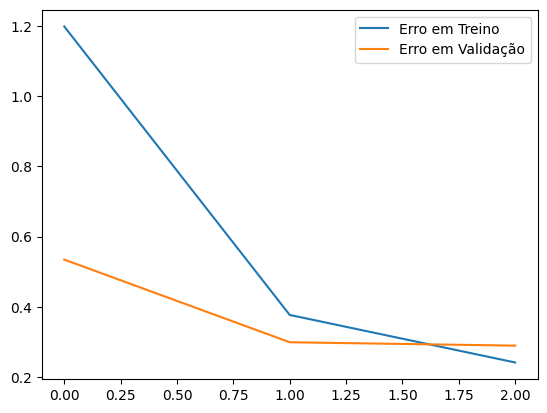

In [133]:
# Curvas de aprendizado
loss, val_loss = history.history['loss'], history.history['val_loss']
plt.plot(loss, label = 'Erro em Treino')
plt.plot(val_loss, label = 'Erro em Validação')
plt.legend()
plt.show()

In [134]:
# Previsões
previsoes = modelo_dsa_v3.predict(X_teste_final)

63/63 [==============================] - 8s 109ms/step


In [135]:
# Labels
labels_previstos = previsoes.argmax(axis = 1)

In [136]:
print(classification_report(y_teste_le, labels_previstos))

              precision    recall  f1-score   support

           0       0.85      0.93      0.89       275
           1       0.83      0.92      0.88       224
           2       0.95      0.88      0.92       695
           3       0.74      0.81      0.77       159
           4       0.94      0.92      0.93       581
           5       0.79      0.70      0.74        66

    accuracy                           0.89      2000
   macro avg       0.85      0.86      0.85      2000
weighted avg       0.90      0.89      0.89      2000



In [137]:
print(confusion_matrix(y_teste_le, labels_previstos))

[[256   8   5   0   6   0]
 [  8 207   0   1   7   1]
 [ 12   5 615  41  12  10]
 [  5   0  15 128  10   1]
 [ 21  11  13   3 533   0]
 [  0  18   0   0   2  46]]


In [138]:
print(accuracy_score(y_teste_le, labels_previstos))

0.8925


In [139]:
# Salva o modelo no formato do TensorFlow
modelo_dsa_v3.save("modelo_dsa_v3.keras", save_format = 'tf')

> Deploy do Modelo.

Nota: O TensorFlow não reconhece automaticamente camadas personalizadas ou objetos que não fazem parte do núcleo do Keras/TensorFlow, como é o caso do TFDistilBertModel do pacote transformers.

Para resolver isso, você precisa registrar a camada personalizada (neste caso, TFDistilBertModel) antes de carregar o modelo, conforme abaixo:

In [140]:
# Carregando o modelo

# Imports
from transformers import TFDistilBertModel
from tensorflow.keras.utils import custom_object_scope

# Registra camada personalizada e carrega o modelo
with custom_object_scope({'TFDistilBertModel': TFDistilBertModel}):
    modelo_recarregado = tf.keras.models.load_model("modelo_dsa_v3.keras")

In [141]:
# Nova frase (sentimento = medo (fear))
frase = "i even feel a little shaky"

In [142]:
# Cria um dataframe com a frase
df_novo = pd.DataFrame({'Frase': [frase]})

In [143]:
# Aplica a função de processamento
df_novo['Frase_Processada'] = df_novo['Frase'].apply(dsa_preprocessa_texto)

In [144]:
novos_dados = dsa_encode(df_novo['Frase_Processada'], fast_tokenizer, maxlen = max_length)

100%|██████████| 1/1 [00:00<00:00, 963.32it/s]


In [145]:
# Fazer previsões com o modelo carregado
previsoes = modelo_recarregado.predict(novos_dados)

1/1 [==============================] - 1s 1s/step


In [146]:
# Seleciona a classe com maior probabilidade
classe_maior_prob = np.argmax(previsoes, axis = 1)

In [147]:
classe_maior_prob

array([1])

In [148]:
# Obtém o nome da classe
nome_classe = dsa_le_v3.inverse_transform(classe_maior_prob)

In [149]:
# Classe prevista
nome_classe

array(['fear'], dtype=object)

Foram 3 modelos treinados, 3 modelos avaliados, 3 modelos implementados (deploy). Todo o processo mostrado passo a passo, 3 vezes, com 3 arquiteturas de Deep Learning diferentes e 3 diferentes estratégias de processamento dos dados.

E este foi apenas o Projeto 2 do curso. ;-)

In [150]:
# Desliga o paralelismo do pacote Transformer
%env TOKENIZERS_PARALLELISM=false

env: TOKENIZERS_PARALLELISM=false


In [151]:
%watermark -a "Data Science Academy"

Author: Data Science Academy



In [152]:
#%watermark -v -m

In [153]:
#%watermark --iversions

# Fim